In [1]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/train_fe.pkl')
test_data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/ieee-fraud-detection/Data/test_fe.pkl')

In [8]:
def tpr_fpr_threshold_auc(Y, proba):
    
    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, threshold, roc_auc)

In [9]:
#Reference: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

def train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''
    
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [10]:
def best_threshold(threshold,tpr,fpr):
    
    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''
    
    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):
    
    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [11]:
#Reference: https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

def draw_confusion_matrix(Y, predicted):
    
    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

Splitting Data

In [7]:
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, shuffle=False)
del X, y

In [13]:
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    tree_method='gpu_hist',
    random_state=3,
    subsample=0.8,
    max_depth=8,
    colsample_bytree=0.6,
    learning_rate=0.02
)

results = clf.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.79685
[50]	validation_0-auc:0.84842
[100]	validation_0-auc:0.86395
[150]	validation_0-auc:0.88347
[200]	validation_0-auc:0.89596
[250]	validation_0-auc:0.90603
[300]	validation_0-auc:0.91310
[350]	validation_0-auc:0.91810
[400]	validation_0-auc:0.92129
[450]	validation_0-auc:0.92355
[500]	validation_0-auc:0.92492
[550]	validation_0-auc:0.92600
[600]	validation_0-auc:0.92705
[650]	validation_0-auc:0.92788
[700]	validation_0-auc:0.92889
[750]	validation_0-auc:0.92987
[800]	validation_0-auc:0.93065
[850]	validation_0-auc:0.93129
[900]	validation_0-auc:0.93179
[950]	validation_0-auc:0.93207
[1000]	validation_0-auc:0.93251
[1050]	validation_0-auc:0.93273
[1100]	validation_0-auc:0.93338
[1150]	validation_0-auc:0.93352
[1200]	validation_0-auc:0.93391
[1250]	validation_0-auc:0.93416
[1300]	validation_0-auc:0.93405
[1350]	validation_0-auc:0.93412
[1352]	validation_0-auc:0.93415


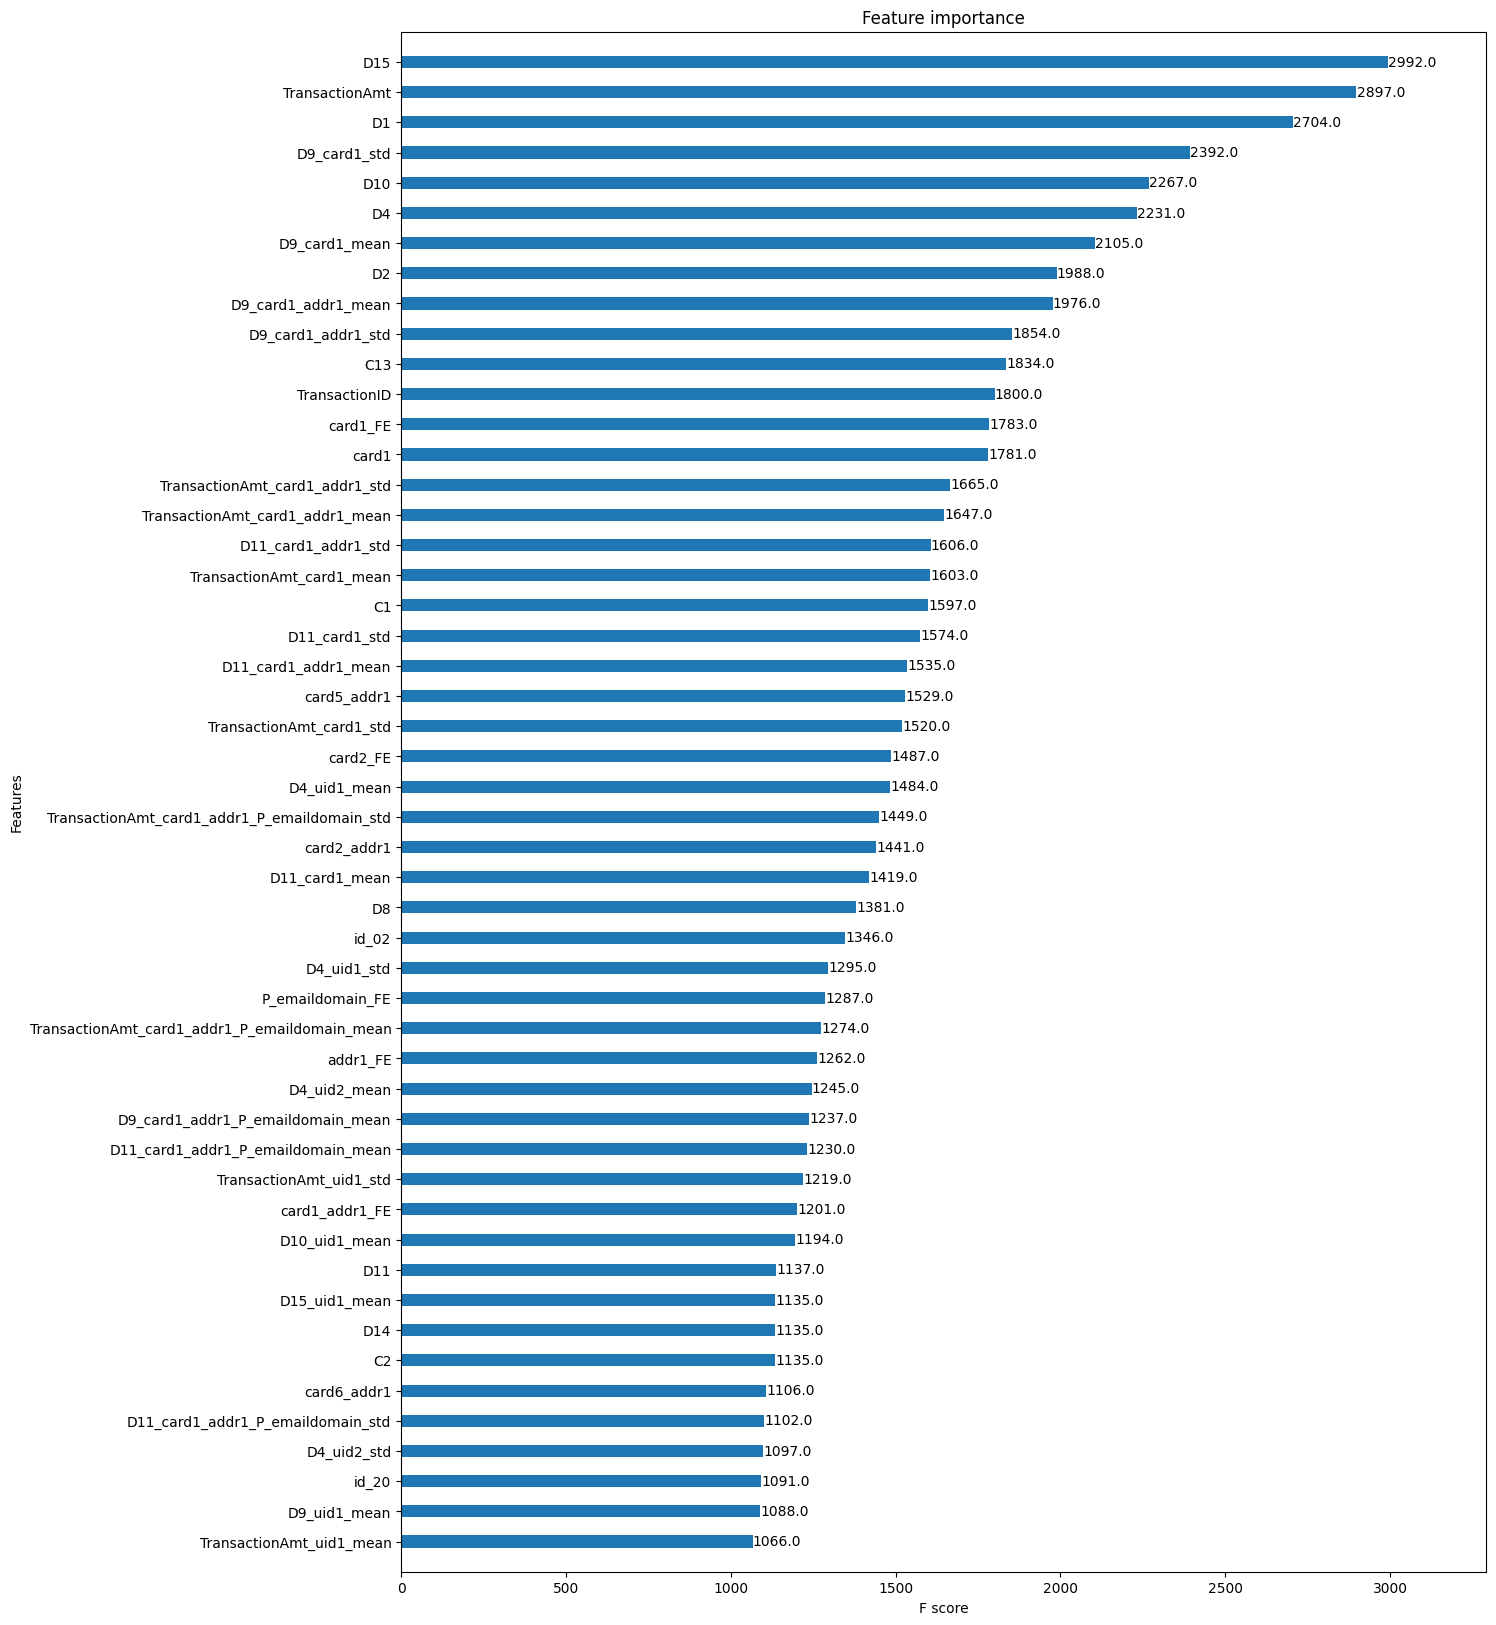

In [14]:
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(clf,max_num_features=50, grid=False, height=0.4)
plt.show()

In [8]:
import joblib
clf = joblib.load('final_model.pkl')

[10:19:03] WARNING: ../src/gbm/gbtree.cc:415: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
[10:19:03] WARNING: ../src/gbm/gbtree.cc:425: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
[10:19:03] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


In [9]:
clf.predict_proba(X_cv)

array([[0.976308  , 0.02369199],
       [0.99832386, 0.00167617],
       [0.7539498 , 0.24605016],
       ...,
       [0.99810576, 0.00189425],
       [0.97617865, 0.02382138],
       [0.9728345 , 0.02716546]], dtype=float32)

In [10]:
clf.predict_proba(X_cv)[:,1]

array([0.02369199, 0.00167617, 0.24605016, ..., 0.00189425, 0.02382138,
       0.02716546], dtype=float32)

In [11]:
train_proba = clf.predict_proba(X_train)[:,1]
cv_proba = clf.predict_proba(X_cv)[:,1]

In [28]:
# creating the dataframe
df1 = pd.DataFrame(data = cv_proba, columns = ['proba'])
df1['TransactionID'] = X_cv['TransactionID'].values

#3545361
#3513782

In [33]:
X_cv[X_cv['TransactionID']==3545361].to_csv('TestfromCV.csv')

In [16]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

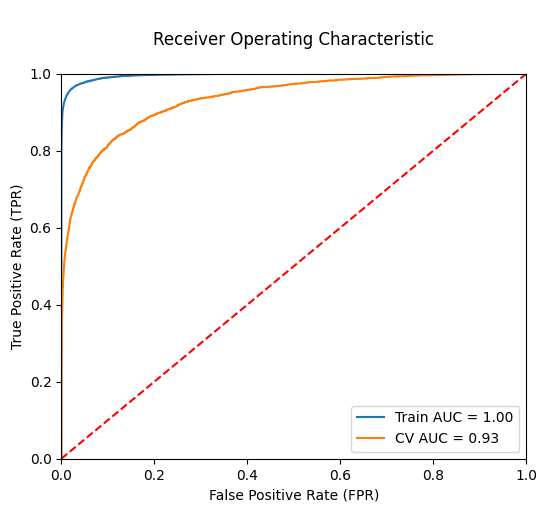

In [17]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

In [29]:
X_train = train_data.drop('isFraud', axis=1)
y_train = train_data['isFraud']

X_test = test_data
test_ids = test_data['TransactionID'].values

cols = [f for f in X_train]

del train_data, test_data

In [ ]:
# https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

test_proba = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)

for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0] 
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
  
    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=3000,
        tree_method='gpu_hist',
        random_state=3,
        subsample=0.8,
        max_depth=8,
        colsample_bytree=0.6,
        learning_rate=0.02
    )      

    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)

    test_proba += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits

Fold 0 withholding month 73
 rows of train = 456201 rows of holdout = 134339
[0]	validation_0-auc:0.75648
[100]	validation_0-auc:0.84866
[200]	validation_0-auc:0.87120
[300]	validation_0-auc:0.88470
[400]	validation_0-auc:0.89317
[500]	validation_0-auc:0.89727
[600]	validation_0-auc:0.89923
[700]	validation_0-auc:0.90035
[800]	validation_0-auc:0.90166
[900]	validation_0-auc:0.90280
[1000]	validation_0-auc:0.90363
[1100]	validation_0-auc:0.90363
[1200]	validation_0-auc:0.90413
[1300]	validation_0-auc:0.90491
[1400]	validation_0-auc:0.90540
[1500]	validation_0-auc:0.90521
[1600]	validation_0-auc:0.90562
[1700]	validation_0-auc:0.90602
[1800]	validation_0-auc:0.90706
[1900]	validation_0-auc:0.90717
[2000]	validation_0-auc:0.90759
[2100]	validation_0-auc:0.90810
[2200]	validation_0-auc:0.90851
[2300]	validation_0-auc:0.90852
[2400]	validation_0-auc:0.90867
[2500]	validation_0-auc:0.90864
[2600]	validation_0-auc:0.90888
[2700]	validation_0-auc:0.90915
[2800]	validation_0-auc:0.90897
[2846]	